<a href="https://colab.research.google.com/github/techthumb1/DS-Unit-2-Kaggle-Challenge/blob/master/module1-decision-trees/Jason_Robinson_DS_221_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [ ] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [78]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [80]:
train, val = train_test_split(train, train_size=0.75, test_size=0.25, 
                              stratify=train['status_group'], random_state=27)

train.shape, val.shape, test.shape

((44550, 41), (14850, 41), (14358, 40))

In [81]:
# Check Pandas Profiling version
import pandas_profiling
pandas_profiling.__version__

'2.5.0'

In [82]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True)
profile.to_notebook_iframe()

In [0]:
import numpy as np

def wrangle(X):
    X = X.copy()
    
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    cols_with_zeros = ['longitude', 'latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
  
    X = X.drop(columns='quantity_group')
    
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [87]:
target = 'status_group'
train_features = train.drop(columns=[target, 'id'])
train_features.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group
45832,0.0,2011-04-03,NaN,0,NaN,34.313634,-8.672661,Kwa Kigwila,0,Rufiji,Forest,Mbeya,12,7,Mbarali,Ubaruku,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe
45599,0.0,2013-02-24,Government Of Tanzania,1441,DWE,37.425986,-3.301422,Mrimbo,0,Pangani,Mrimbo,Kilimanjaro,3,4,Moshi Rural,Kimochi,70,True,GeoData Consultants Ltd,VWC,Kimarare,True,1974,gravity,gravity,gravity,vwc,user-group,unknown,unknown,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe
14636,1000.0,2013-02-14,Norad,1283,RWE/DWE,30.554751,-3.626613,Bakuliwavu,0,Lake Tanganyika,Soweto,Kigoma,16,1,Kibondo,Itaba,350,True,GeoData Consultants Ltd,VWC,Kigogo gravity water supply,False,1990,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,spring,spring,groundwater,communal standpipe multiple,communal standpipe
2769,0.0,2012-10-07,Tasaf,0,TASAF,34.320146,-3.954663,Zanzibar,0,Internal,Gaigei,Shinyanga,17,6,Meatu,Mwamalole,0,True,GeoData Consultants Ltd,WUG,None,True,0,other,other,other,wug,user-group,never pay,never pay,soft,good,dry,shallow well,shallow well,groundwater,hand pump,hand pump
32603,0.0,2012-10-07,Netherlands,0,DWE,33.750392,-3.072157,Siguka Groups,0,Lake Victoria,Ging'Hi,Shinyanga,17,2,Maswa,Buchambi,0,True,GeoData Consultants Ltd,WUG,NaN,False,0,nira/tanira,nira/tanira,handpump,wug,user-group,pay when scheme fails,on failure,soft,good,enough,shallow well,shallow well,groundwater,hand pump,hand pump


In [88]:
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
numeric_features

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'region_code',
 'district_code',
 'population',
 'construction_year']

In [89]:
cardinality = train_features.select_dtypes(exclude='number').nunique()
cardinality

date_recorded              345
funder                    1635
installer                 1841
wpt_name                 28962
basin                        9
subvillage               16651
region                      21
lga                        125
ward                      2084
public_meeting               2
recorded_by                  1
scheme_management           11
scheme_name               2495
permit                       2
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity                     5
source                      10
source_type                  7
source_class                 3
waterpoint_type              7
waterpoint_type_group        6
dtype: int64

In [90]:
categorical_features = cardinality[cardinality <= 10].index.tolist()
features = numeric_features + categorical_features
print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'basin', 'public_meeting', 'recorded_by', 'permit', 'extraction_type_class', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [0]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

In [93]:
dt = make_pipeline(
     ce.OneHotEncoder(use_cat_names=True),
     SimpleImputer(strategy='median'),
     StandardScaler(),
     DecisionTreeClassifier(max_depth=15, random_state=12, min_samples_leaf=5))
    
dt.fit(X_train, y_train)    
print(f'Train accuracy: {dt.score(X_train, y_train)}')
print(f'Validation accuracy: {dt.score(X_val, y_val)}')

Train accuracy: 0.8080808080808081
Validation accuracy: 0.7651851851851852


In [75]:
y_pred = dt.predict(X_test)
y_pred

array(['non functional', 'functional', 'non functional', ...,
       'functional', 'functional', 'non functional'], dtype=object)

In [0]:
y_pred = dt.predict(X_test)

submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission_1.csv', index=False)

In [48]:
sample_submission.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,functional
4,49871,functional


In [14]:
from google.colab import drive

drive.mount('/gdrive')
with open('/gdrive/My Drive/foo.csv', 'w') as f:
  submission.to_csv(f)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [16]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [0]:
submission.to_csv('submission.csv', index=False)
!cp submission.csv "drive/My Drive/"

In [0]:
from google.colab import files
files.download('submission.csv')

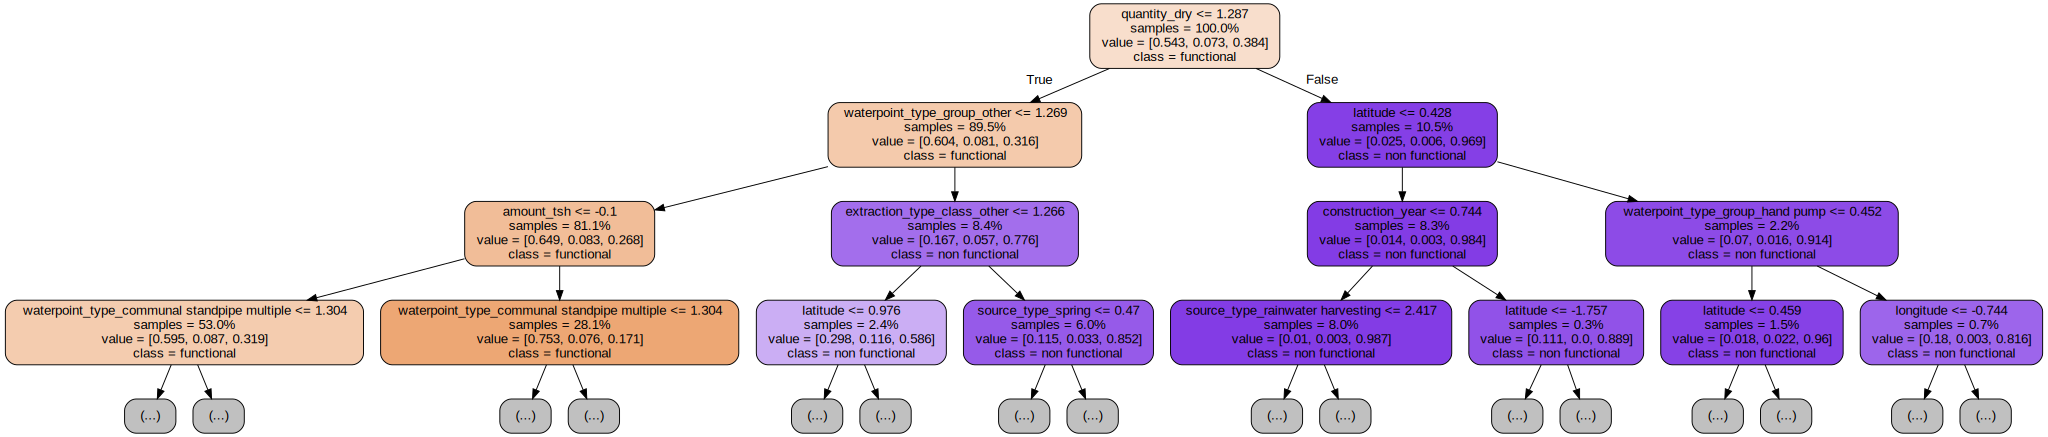

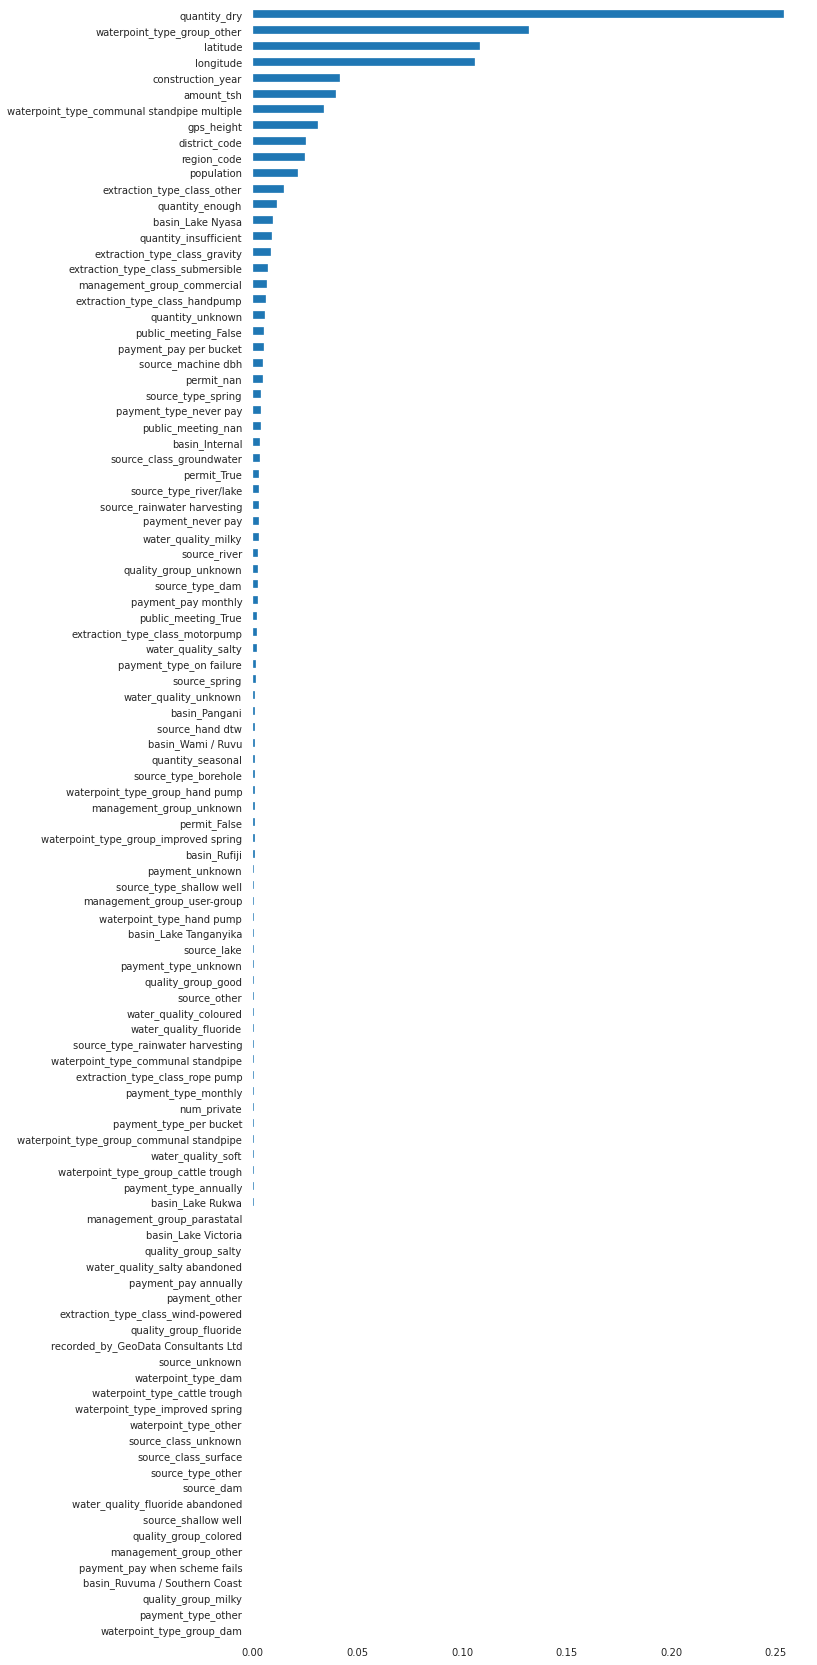

In [96]:
import graphviz
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
%matplotlib inline

model = dt.named_steps['decisiontreeclassifier']
encoder = dt.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10, 30))
importances.sort_values().plot.barh()

dot_data = export_graphviz(model, 
                           out_file=None, 
                           max_depth=3, 
                           feature_names=encoded_columns,
                           class_names=model.classes_, 
                           impurity=False, 
                           filled=True, 
                           proportion=True, 
                           rounded=True)   
display(graphviz.Source(dot_data))